# Scale Free Network simulations

In [89]:
import matplotlib.pyplot as plt
import csv
import numpy as np
import EoN
import networkx as nx
import pandas as pd
import scipy.interpolate


N = 10**4
G = nx.barabasi_albert_graph(N, 4)
tmax = 200
simulationRuns = 50
tau = 0.025     #transmission rate
gamma = 0.1     #recovery rate
rho = 0.005     #random fraction initially infected
step = 0.1      #step size

In [90]:
def resample(x, n, kind='linear'):
    f = scipy.interpolate.interp1d(np.linspace(0, 1, x.size), x, kind)
    return f(np.linspace(0, 1, n))

No handles with labels found to put in legend.


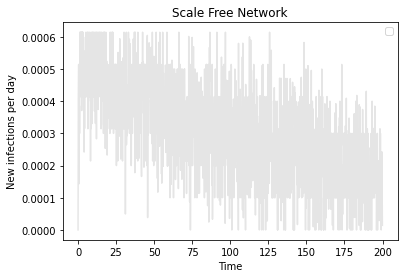

<Figure size 432x288 with 0 Axes>

In [123]:
x = np.arange(0, tmax, step)
y = np.arange(0, tmax, step)

# for counter in range(simulationRuns):
t, S, I, R = EoN.fast_SIR(G, tau, gamma, rho = rho, tmax = tmax)
S = resample(S, int(tmax/step))/N
incidence = - np.diff(S)
incidence = np.concatenate(([0], incidence))
if counter == 0:
    plt.plot(x, incidence, color = 'gray', alpha = 0.2, label = 'Individual simulation runs')
plt.plot(x, incidence, color = 'gray', alpha = 0.2)

#df1 = pd.read_csv('Sources/Aparicio_ScaleFreS.csv')
#df1 = df1.loc[:, '{#status->#S}']
#inc1 = - df1.diff()*N
#inc1 = inc1[:2000]

#df2 = pd.read_csv('Sources/Stroud_HMS.csv')
#df2 = df2.loc[:, '{#status->#S}']
#inc2 = - df2.diff()*N
#inc2 = inc2[:2000]

#df3 = pd.read_csv('Sources/Stroud_ScaleS.csv')
#df3 = df3.loc[:, '{#status->#S}']
#inc3 = - df3.diff()*N
#inc3 = inc3[:2000]

#plt.plot(x, inc1, '--', label = 'Aparicio simulation', color = 'green')
#plt.plot(x, inc2, label = 'Homogeneous mixing simulation', color = 'red')
#plt.plot(x, inc3, '-.', label = 'Stroud simulation', color = 'blue')

plt.xlabel('Time')
plt.ylabel('New infections per day')
plt.title('Scale Free Network')
plt.legend()
plt.show()
plt.savefig('Plot/Scale_Free_network.png')

In [112]:
incidence

array([50.        ,  5.95697849,  3.95697849, ...,  2.08604302,
        0.91395698,  1.        ])

In [46]:
print(S)

[9950 9950 9949 ... 3965 3965 3965]


In [55]:
incidence

array([50,  1,  1, ...,  0,  0,  0])

In [60]:
I.max()

1441

In [113]:
a = np.array([1,2,3,4,5,6,7,8,9,10])

In [115]:
resample(a, 5, kind='linear')

array([ 1.  ,  3.25,  5.5 ,  7.75, 10.  ])

In [116]:
S

array([9950.        , 9944.04302151, 9940.08604302, ..., 4022.91395698,
       4022.        , 4021.        ])

In [117]:
S.size

2000